In [ ]:
setwd('~/Desktop/HW/introduction-to-bioinformatics/project/')
library(GEOquery)
library(limma)
library(umap)
library(pheatmap)
library(gplots)
library(ggplot2)
library(reshape2)
library(plyr)
library(repr)
library(gridExtra)
library(ggpubr)

In [2]:
gset <- getGEO("GSE48558", GSEMatrix =TRUE, getGPL=T, destdir='Data/')
gset <- gset[[1]]

Found 1 file(s)

GSE48558_series_matrix.txt.gz

Using locally cached version: Data//GSE48558_series_matrix.txt.gz

Using locally cached version of GPL6244 found here:
Data//GPL6244.soft.gz 



In [3]:
gsms <- paste0("0000000000000XXXXXXXXXXXXXXXXXXXXXXXXXXX1XXX1XXXXX",
               "XXXXXXXXXXXXXXXXXX2X3XXX1X1442X3XX33XX33X2X3X2X3X5",
               "XXX5XXX5XXXXXXXXXXXXXXXXXXXXXXXXXXXXX1111111003000",
               "22222223444413333333")
sml <- strsplit(gsms, split="")[[1]]
sel <- which(sml != "X")
sml <- sml[sel]
gset <- gset[ ,sel]

In [4]:
gs <- factor(sml)
groups <- make.names(c("AML","GRLC","B","T","MNC","CD34"))
levels(gs) <- groups
gset$group <- gs

In [5]:
ex <- exprs(gset)

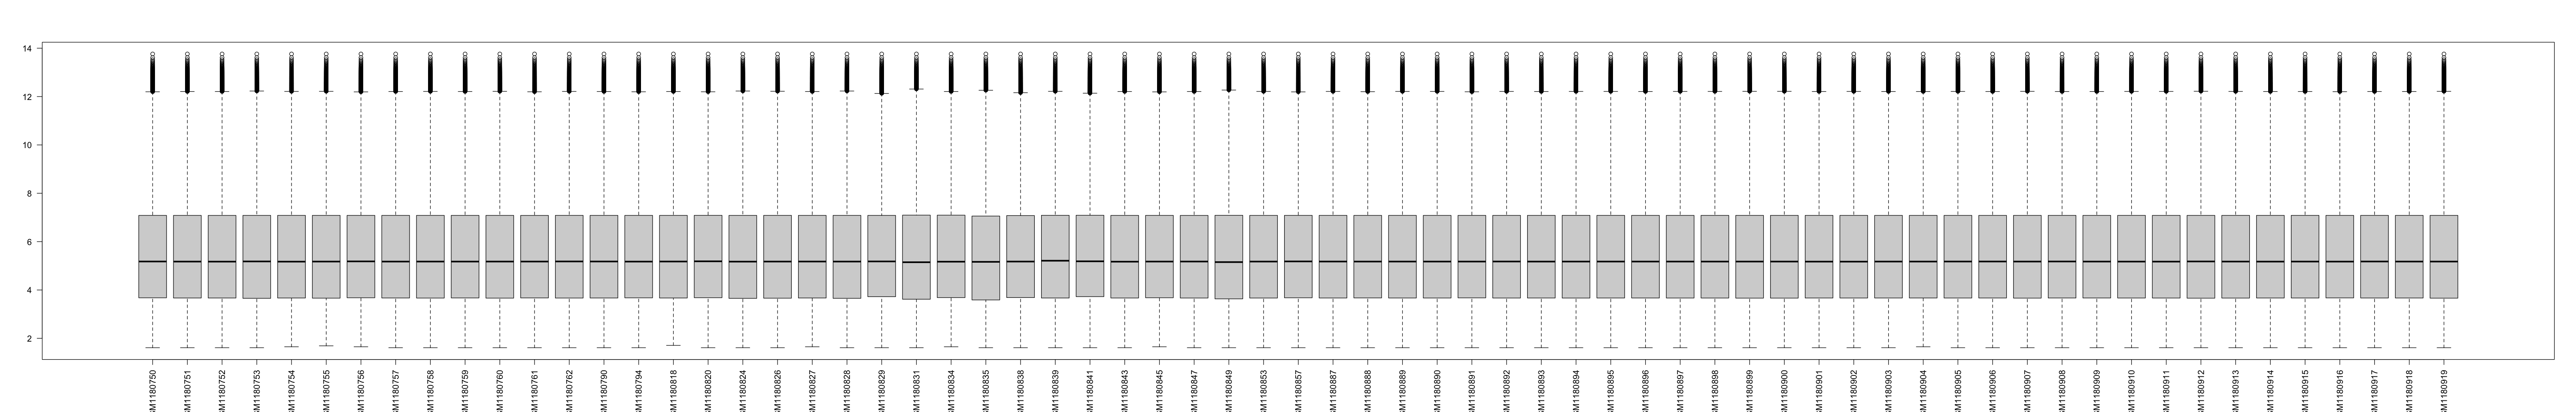

In [16]:
options(repr.plot.width=50, repr.plot.height=8)
boxplot(ex, las = 2)

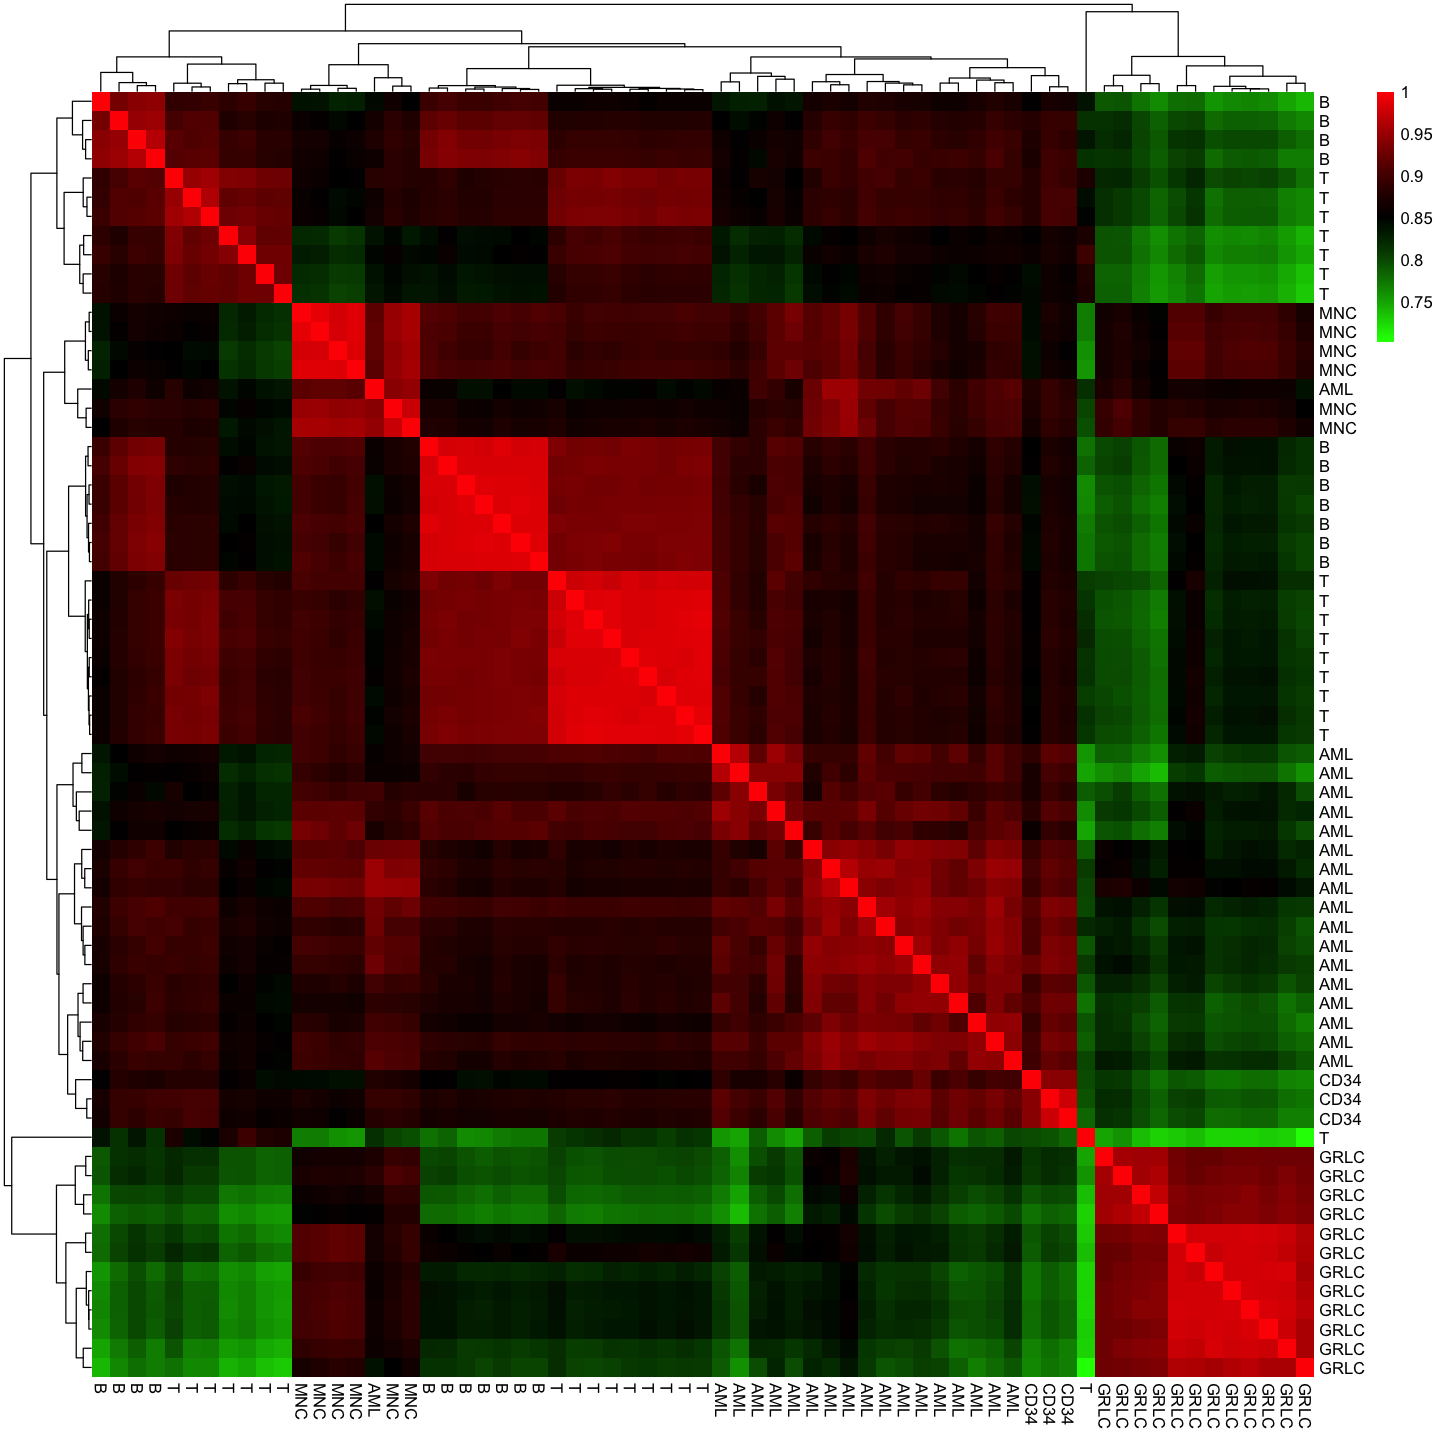

In [19]:
options(repr.plot.width=12, repr.plot.height=12)
pheatmap(cor(ex),
         labels_row = gs,
         labels_col = gs,
         color = greenred(256),
         border_color = NA,)

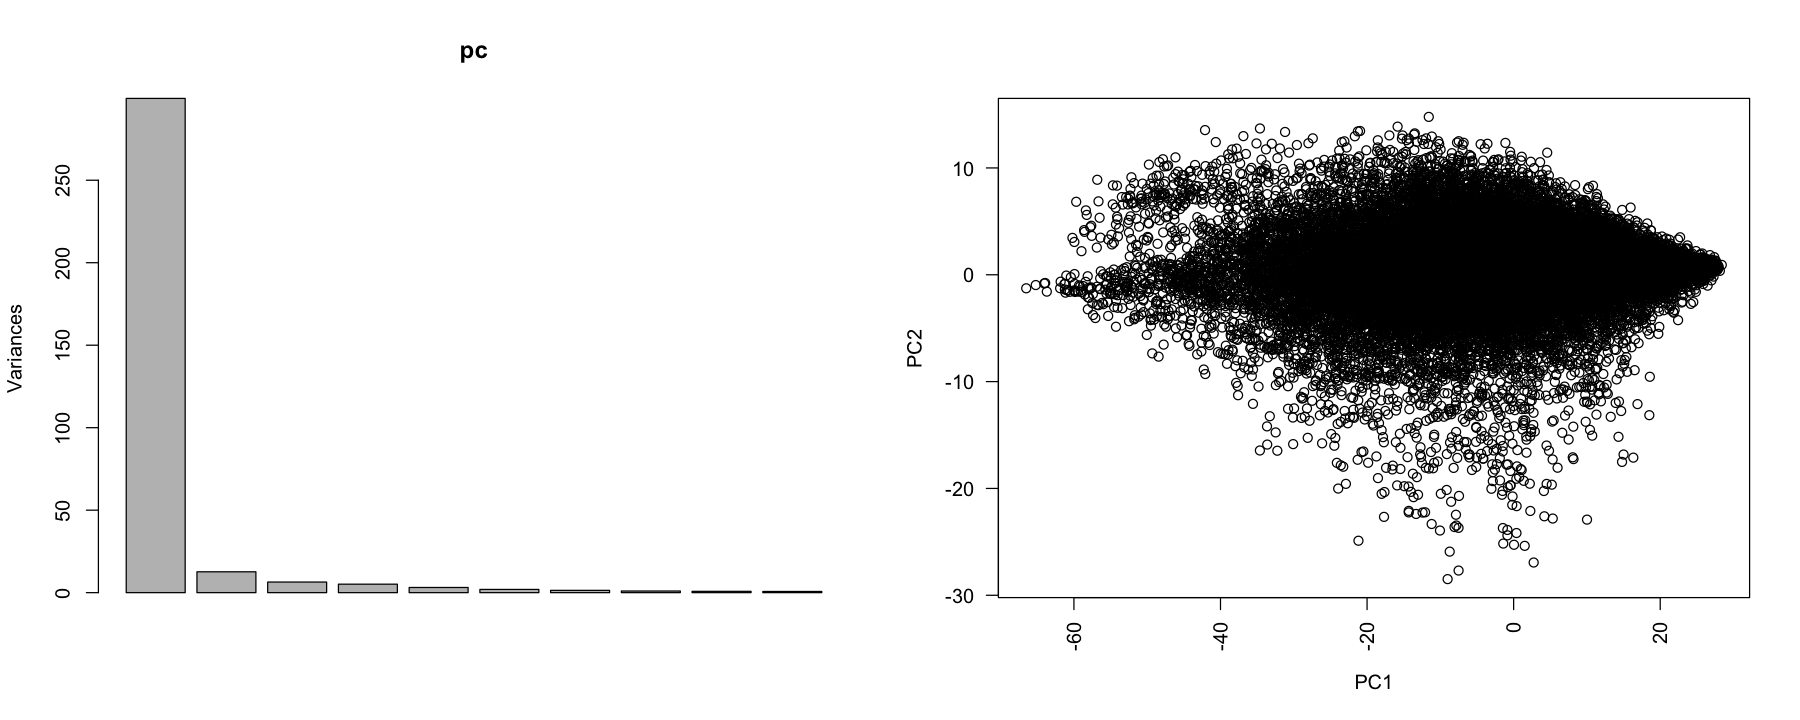

In [37]:
pc <- prcomp(ex)
options(repr.plot.width=15, repr.plot.height=6)
par(mfrow = c(1, 2))
p1 <- plot(pc)
p2 <- plot(pc$x[, 1:2], las = 2)

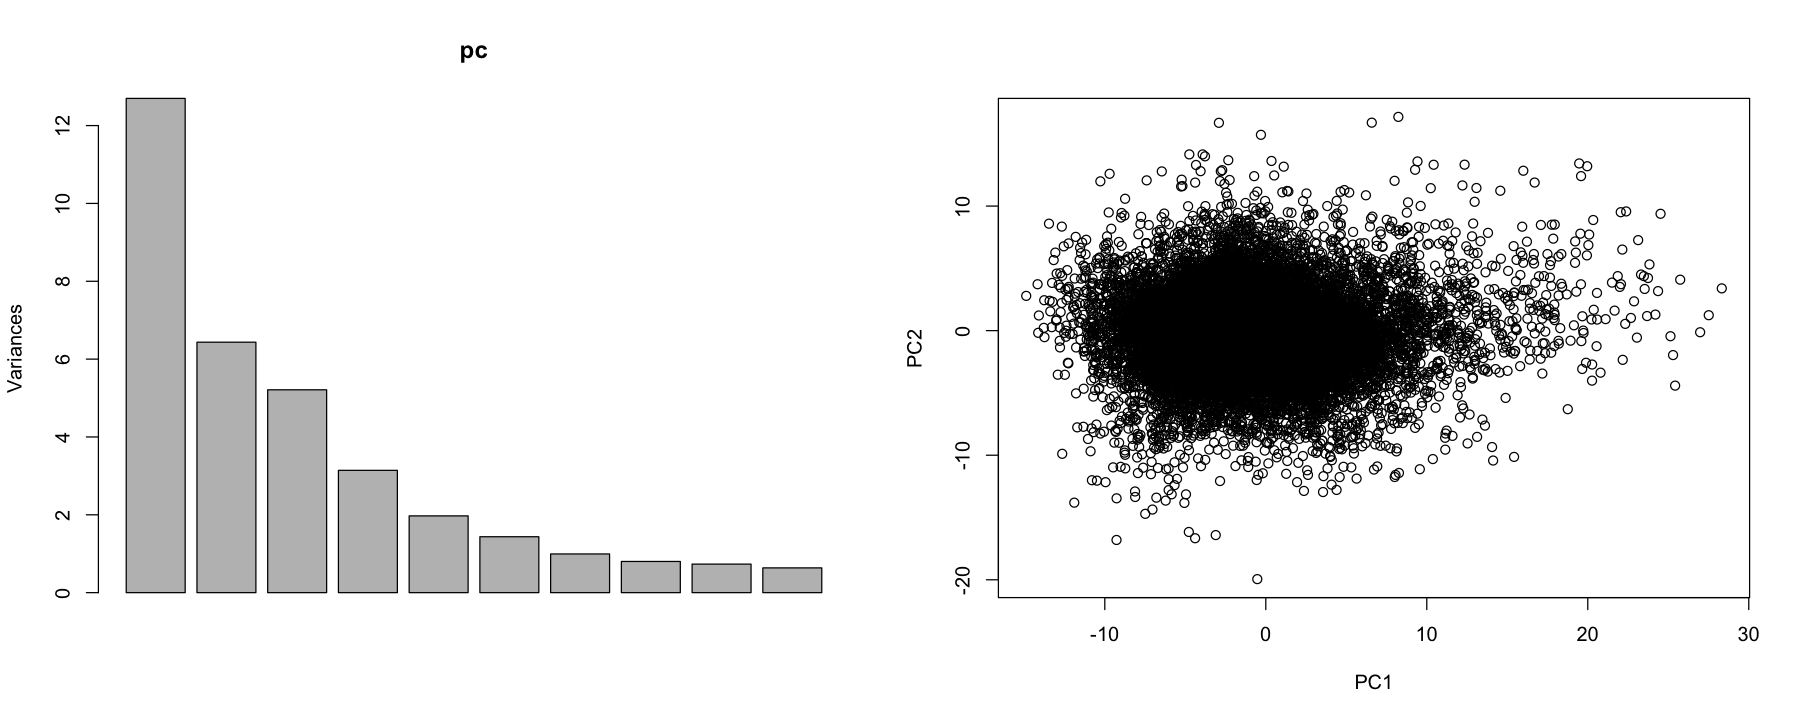

In [39]:
ex.scale <- t(scale(t(ex), scale = F))
pc <- prcomp(ex.scale)

options(repr.plot.width=15, repr.plot.height=6)
par(mfrow = c(1, 2))

plot(pc)
plot(pc$x[, 1:2]) # x column are genes (so each point in this plot represents a gene)

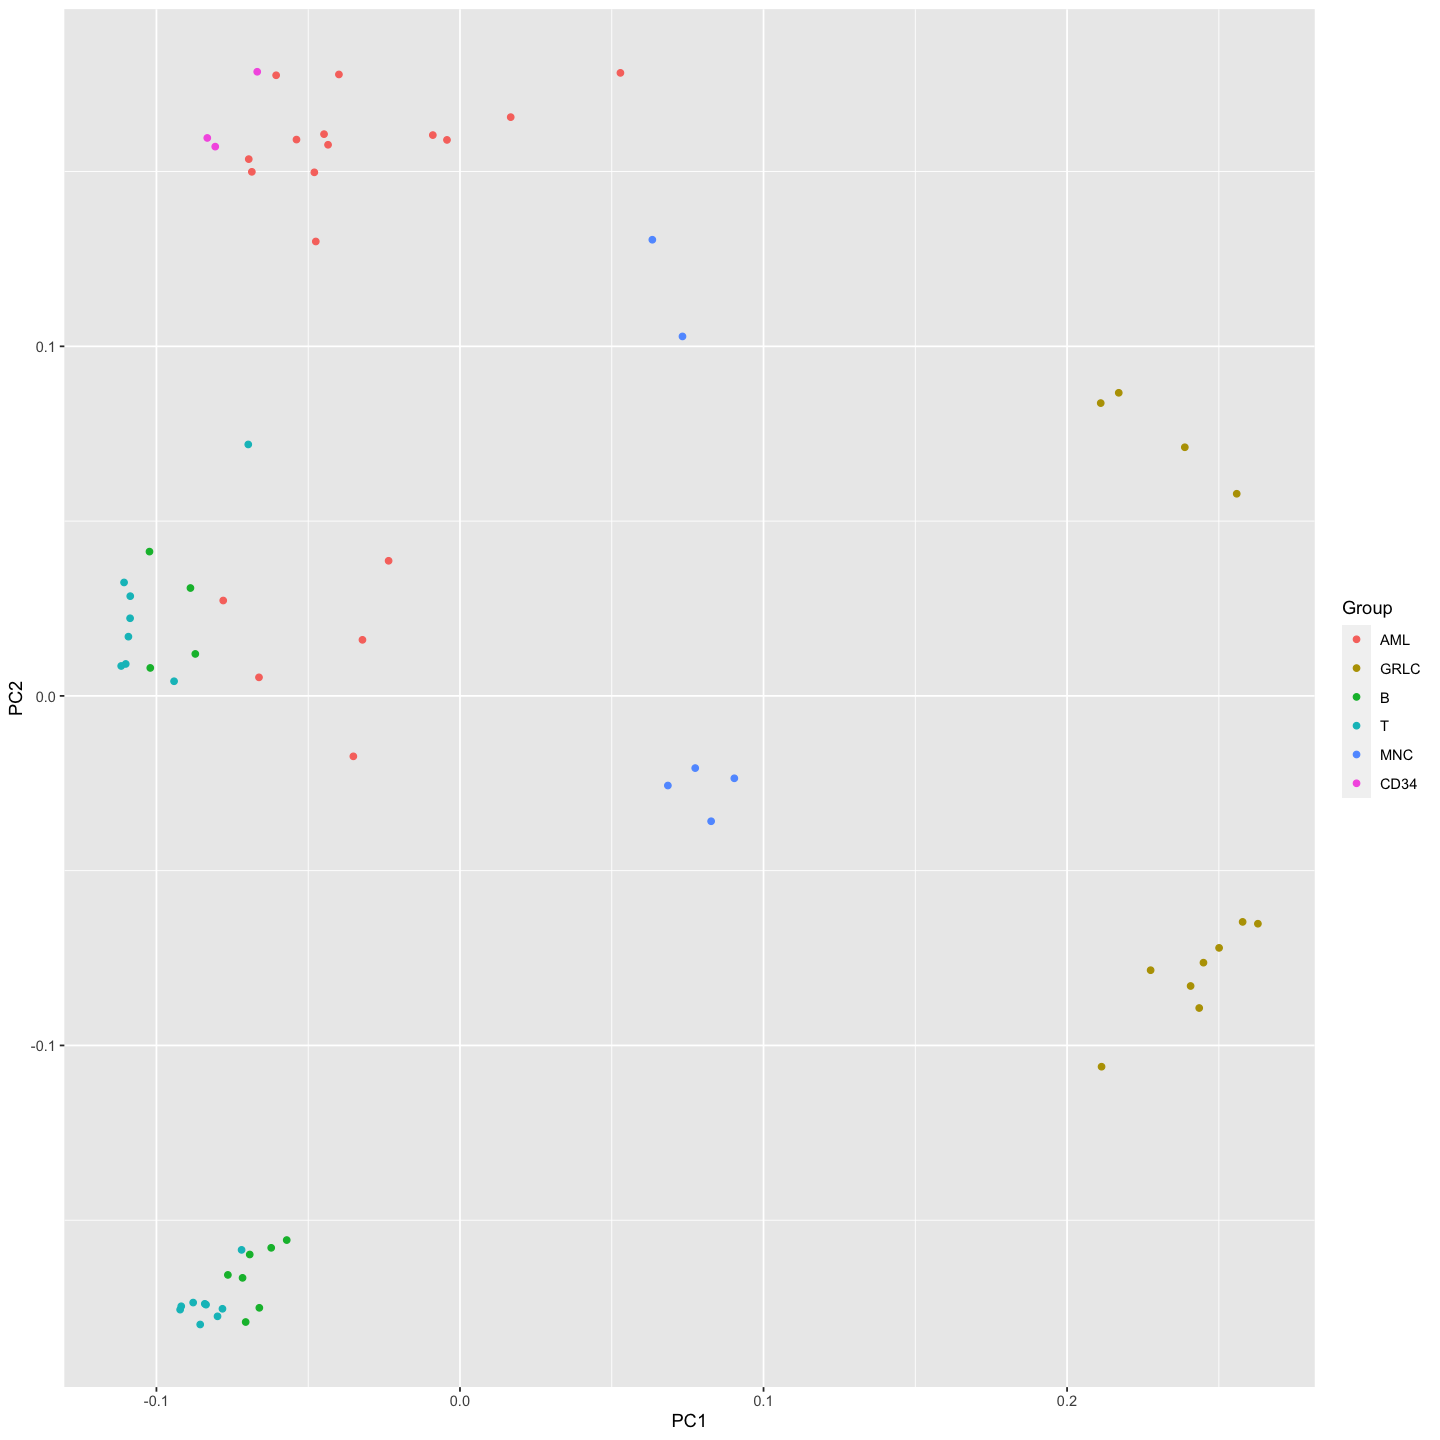

In [44]:
pcr <- data.frame(pc$rotation[, 1:3], Group=gs)
options(repr.plot.width=12, repr.plot.height=12)
ggplot(pcr, aes(x = PC1, y = PC2, color = Group)) + geom_point() + theme_gray()

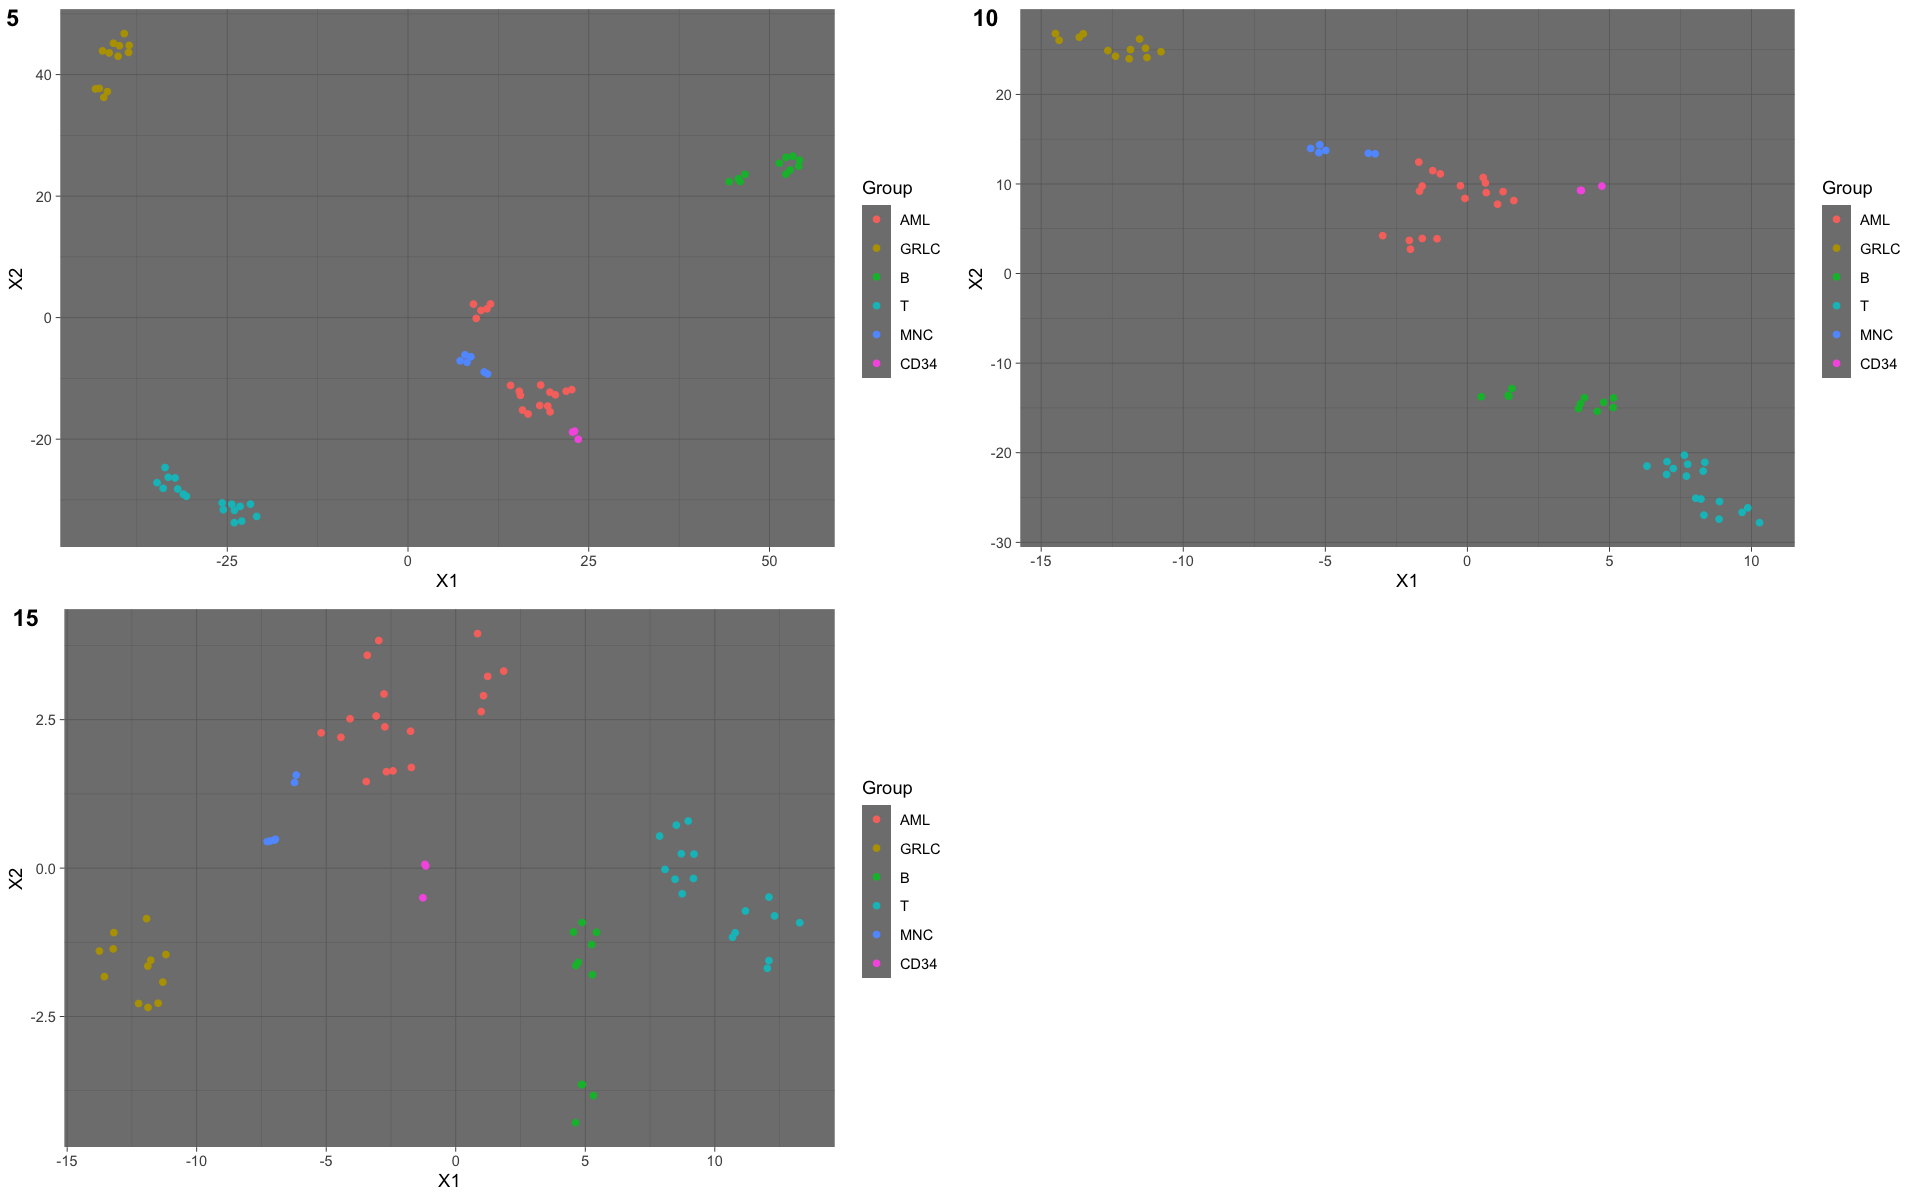

In [71]:
library(Rtsne)

tsne_results <- list(Rtsne(t(ex), perplexity=5, check_duplicates = FALSE),
                     Rtsne(t(ex), perplexity=10, check_duplicates = FALSE),
                     Rtsne(t(ex), perplexity=15, check_duplicates = FALSE))

options(repr.plot.width=16, repr.plot.height=10)
plots.list <- list()

for(i in seq_along(tsne_results)) {
  tsne <- data.frame(tsne_results[[i]]$Y[, 1:2], Group=gs)
  plots.list[[i]] <- ggplot(tsne, aes(X1, X2, color = Group)) + geom_point() + theme_dark()
}
ggarrange(plotlist = plots.list,
          ncol = 2,
          nrow = 2,
          labels = c(5, 10, 15))
